In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch

from optiland import optic
from optiland.materials import Material
from optiland.apodization import GaussianApodization
from optiland.analysis.irradiance import IncoherentIrradiance
from optiland.analysis.intensity import RadiantIntensity
from optiland.physical_apertures import RadialAperture, RectangularAperture
import optiland.backend as be

from classes.cartesian_oval import CartesianOvalCollimator
from classes.gaussian_beam import GaussianBeam
from classes.beam_shaper import BeamShaper

be.set_backend("torch")
be.grad_mode.enable()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Optiland backend successfully set to: {be.get_backend()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Optiland backend successfully set to: torch
PyTorch version: 2.10.0+cpu
CUDA available: False


In [2]:
# Gaussian Source Parameters
wavelength = np.array([1.55]) # in micrometers
omega_0 = 5.2 # in micrometers

In [3]:
H_LAF3B = Material(name="H-LAF3B")
print(H_LAF3B.n(wavelength[0]))

index1 = float(H_LAF3B.n(wavelength = wavelength[0]))

[1.718545]


C:\Users\shown\AppData\Local\Temp\ipykernel_29516\2153177057.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index1 = float(H_LAF3B.n(wavelength = wavelength[0]))


In [4]:
source = GaussianBeam(
    wavelength=float(wavelength[0]),
    omega_0=omega_0,
)

beam_size = source.beam_radius(z=30) # in millimeters at z = 30 mm

semi_dia = np.ceil(beam_size)

# Glass: CDGM H-LAF3B
collimator = CartesianOvalCollimator(
    z_0=30, # in millimeters
    n = index1, # refractive index of the collimator material
    r_max=semi_dia, # in millimeters    
)

approx_ea = collimator.paraxial_fit()
fitted_ea = collimator.even_aspheric_fitting(approx_ea)


In [5]:
print("Source Information:")
print(f"omega(z=30mm): {beam_size} millimeters")
print("Rayleigh Range: {:.4f} um".format(source.rayleigh_range))
print("Divergence Angle (half-angle): {:.4f} urad".format(source.div_angle * 1e3))
print("Divergence Angle (half-angle): {:.4f} degrees".format(np.degrees(source.div_angle)))
print("Divergence Angle at z = 30 mm: {:.4f} degrees".format(np.degrees(source.div_angle_z(z=30))))
print("object NA=", np.sin(source.div_angle))


Source Information:
omega(z=30mm): 2.846429693572783 millimeters
Rayleigh Range: 54.8056 um
Divergence Angle (half-angle): 94.8808 urad
Divergence Angle (half-angle): 5.4363 degrees
Divergence Angle at z = 30 mm: 5.4201 degrees
object NA= 0.09473853676366122


In [6]:
print("Collimator Surface Information:")
print(f"Collimator semi-diameter: {collimator.r_max} millimeters")
print("\n")
print(f"Paraxial fit radius: {approx_ea.vertex_r} millimeters")
print(f"Paraxial fit conic constant: {approx_ea.k}")
print("\n")
print(f"Fitted even aspheric radius: {fitted_ea.vertex_r} millimeters")
print(f"Fitted even aspheric conic constant: {fitted_ea.k}")

Collimator Surface Information:
Collimator semi-diameter: 3.0 millimeters


Paraxial fit radius: 21.556350116103832 millimeters
Paraxial fit conic constant: -2.9533969303269774


Fitted even aspheric radius: 21.556350116103832 millimeters
Fitted even aspheric conic constant: -2.9533969303269774


In [10]:
emitter = optic.Optic()

# Set System Data
emitter.set_aperture(aperture_type="objectNA", value=np.sin(source.div_angle)) # "EPD", "imageFNO"

emitter.set_field_type(field_type = "angle") # "object_height"; "paraxial_image_height"; "real_image_height"; "angle"
emitter.add_field(y=0)

emitter.add_wavelength(value=wavelength[0], is_primary=True)

gaussian_apo = GaussianApodization(sigma=1/np.sqrt(2)) # I = exp(-(Px^2 + Py^2) / (2 * self.sigma^2)) => sigma = 1/sqrt(2G) where apodization factor G = 1 in this case 
emitter.set_apodization(gaussian_apo)

# Set Lens Data
detector_aperture1 = RectangularAperture(
    x_min = -semi_dia,
    x_max = semi_dia,
    y_min = -semi_dia,
    y_max = semi_dia,
)

radial_aperture1 = RadialAperture(r_max=semi_dia)
radial_aperture2 = RadialAperture(r_max=16)

detector_aperture2 = RectangularAperture(
    x_min = -16,
    x_max = 16,
    y_min = -16,
    y_max = 16,
)


# Point source
emitter.add_surface(index=0, radius=np.inf, thickness=collimator.z_0, comment="Point Source")

# detector surface 1
emitter.add_surface(index=1, radius=np.inf, thickness=0, comment="Dummy surface", aperture=detector_aperture1)

# Collimator surface
emitter.add_surface(index=2, thickness=4, is_stop=True, radius=approx_ea.vertex_r, conic=approx_ea.k, material=H_LAF3B, comment="Collimator surface", aperture=radial_aperture1)

### Calculate beam shaper parameters
beam_shaper = BeamShaper(omega=beam_size,
                         r_max=beam_size,
                         R_max=10,
                         d=20,
                         n=index1,
                         type="Galilean",
                         approx=True
)
###

# Beam shaper surface 1
emitter.add_surface(index=3, radius=beam_shaper.r_c1, thickness=20, conic=beam_shaper.k_1, comment="Beam shaper surface 1", aperture=radial_aperture1)

# Beam shaper surface 2
emitter.add_surface(index=4, radius=beam_shaper.r_c2, thickness=7, conic=beam_shaper.k_2, material=H_LAF3B, comment="Beam shaper surface 2", aperture=radial_aperture2)

emitter.add_surface(index=5, radius=np.inf, thickness=50, comment="Beam shaper exit", aperture = radial_aperture2)

# Image plane, crucial for right lens.draw()
emitter.add_surface(index=6, radius=np.inf, thickness=0, comment="Image plane", aperture=detector_aperture2)

emitter.update_paraxial()

In [11]:
emitter.info()

╒════╤═════════════════╤═══════════════════════╤═══════════╤═════════════╤════════════╤══════════╤═════════════════╕
│    │ Type            │ Comment               │    Radius │   Thickness │ Material   │    Conic │   Semi-aperture │
╞════╪═════════════════╪═══════════════════════╪═══════════╪═════════════╪════════════╪══════════╪═════════════════╡
│  0 │ Planar          │ Point Source          │ inf       │          30 │ Air        │  0       │          0      │
│  1 │ Planar          │ Dummy surface         │ inf       │           0 │ Air        │  0       │          2.855  │
│  2 │ Stop - Standard │ Collimator surface    │  21.5564  │           4 │ H-LAF3B    │ -2.9534  │          3      │
│  3 │ Standard        │ Beam shaper surface 1 │   3.30893 │          20 │ Air        │ -4.92132 │          3      │
│  4 │ Standard        │ Beam shaper surface 2 │  17.6798  │           7 │ H-LAF3B    │ -3.32171 │         16      │
│  5 │ Planar          │ Beam shaper exit      │ inf       │    

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

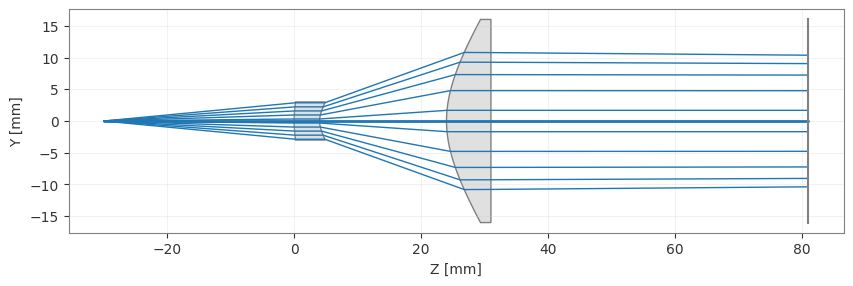

In [12]:
emitter.draw(num_rays=10, distribution="cross") # "line_x", "line_y", "positive_line_x", "positive_line_y", "random", "uniform", "hexapolar", "cross", "ring"

In [138]:
rays = emitter.trace(Hx=0, Hy=0, wavelength=wavelength[0], num_rays=200, distribution="cross") 

# Irradiance

In [ ]:
src_irr = IncoherentIrradiance(emitter, num_rays = 10000, detector_surface = 1, distribution="uniform")

(400,)
(400,)
(400,)
(400,)


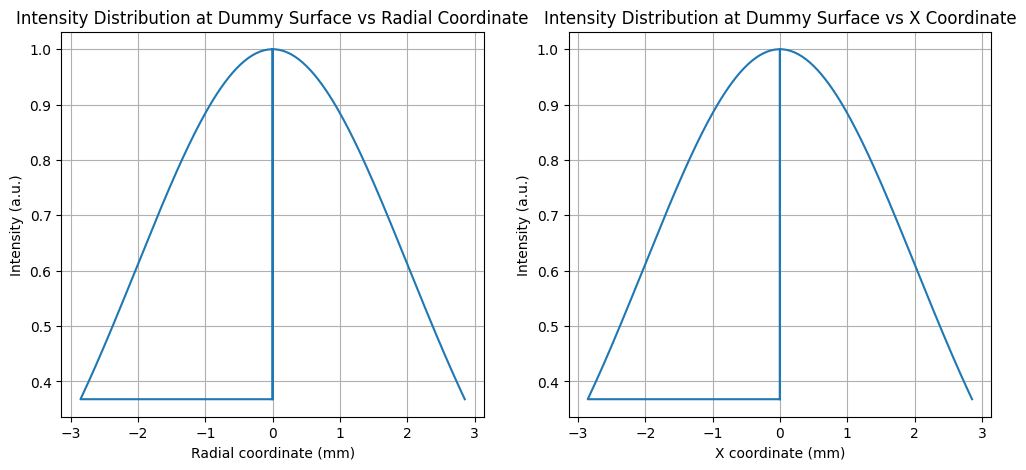

In [139]:
dummy_surf = emitter.surface_group.surfaces[1]
intensity = dummy_surf.intensity

print(intensity.shape)
print(rays.i.shape)
print(dummy_surf.x.shape)   

x = dummy_surf.x
y = dummy_surf.y
r = x**2 + y**2
r = np.sign(x) * np.sqrt(r)  

print(r.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(r, intensity)
ax1.set_xlabel("Radial coordinate (mm)")
ax1.set_ylabel("Intensity (a.u.)")
ax1.set_title("Intensity Distribution at Dummy Surface vs Radial Coordinate")
ax1.grid()

ax2.plot(x, intensity)
ax2.set_xlabel("X coordinate (mm)")
ax2.set_ylabel("Intensity (a.u.)")
ax2.set_title("Intensity Distribution at Dummy Surface vs X Coordinate")
ax2.grid()

plt.show()

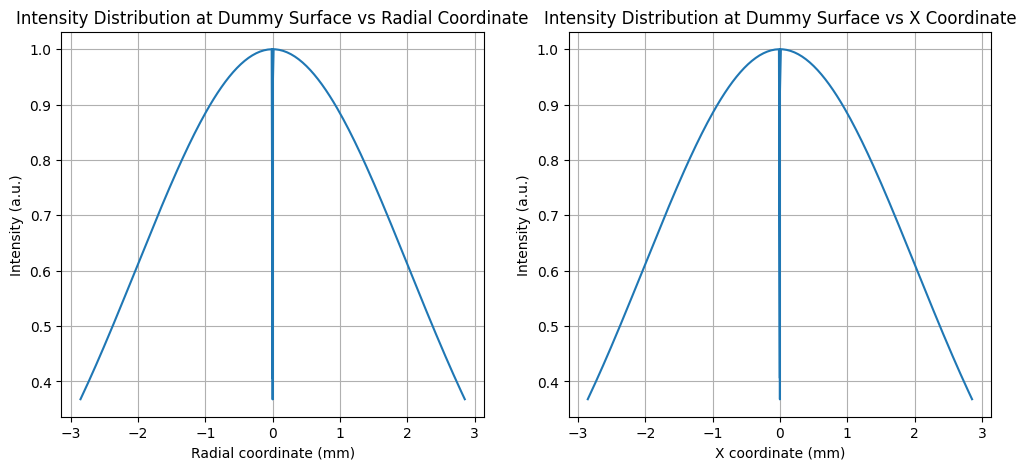

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

idx_r = np.argsort(r)
ax1.plot(r[idx_r], intensity[idx_r])
ax1.set_xlabel("Radial coordinate (mm)")
ax1.set_ylabel("Intensity (a.u.)")
ax1.set_title("Intensity Distribution at Dummy Surface vs Radial Coordinate")
ax1.grid()

id_x = np.argsort(x)
ax2.plot(x[id_x], intensity[id_x])
ax2.set_xlabel("X coordinate (mm)")
ax2.set_ylabel("Intensity (a.u.)")
ax2.set_title("Intensity Distribution at Dummy Surface vs X Coordinate")
ax2.grid()

plt.show()

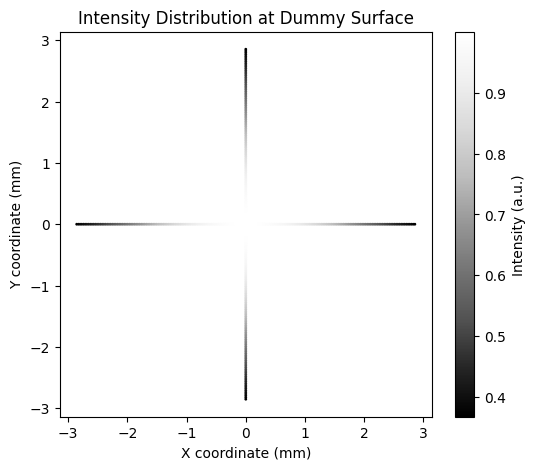

In [141]:
plt.figure(figsize=(6, 5))
plt.scatter(x, y, c=intensity, s=1, cmap='Greys_r')
plt.xlabel("X coordinate (mm)")
plt.ylabel("Y coordinate (mm)")
plt.title("Intensity Distribution at Dummy Surface")
plt.colorbar(label="Intensity (a.u.)")
plt.show()